# Breast Cancer NLP Project

### Goals: Build a model to predict the main programming language of Breast Cancer repositories, by scraping the text in the README file.

In [79]:
## Imports
# import
import requests
import json
import pandas as pd
import unicodedata
import re
import json
import nltk
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from pprint import pprint
from wordcloud import WordCloud
from nltk import bigrams
from nltk import trigrams
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# set up API request headers
from env import github_token, github_username

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

import final_wrangle as w


In [13]:
headers = {
    "Authorization": f"token {github_token}",
    "User-Agent": github_username
}
# make API requests to get repository names
language = "python"
api_url = f"https://api.github.com/search/repositories?q=language:{language}&sort=stars&order=desc&per_page=100"
response = requests.get(api_url, headers=headers)

if response.status_code == 200:
    repositories = response.json()["items"]
else:
    print(f"Failed to fetch repository list. Status code: {response.status_code}")
    exit()

In [24]:

# Define a function to get repositories based on a query and page
def get_repositories(query, sort="stars", order="desc", page=1):
    base_url = "https://api.github.com/search/repositories"
    params = {
        "q": query,
        "sort": sort,
        "order": order,
        "per_page": 10,  # You can get up to 100 results per page.
        "page": page  # Specify the page number
    }
    response = requests.get(base_url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        return None

# Search for breast cancer related repositories and handle pagination
query = "breast cancer"
page = 1

# Create a list to collect the repository data
repository_data = []

while page <= 10:
    response_json = get_repositories(query, page=page)
    if response_json is None:
        print(f"Failed to fetch page {page} of repositories.")
        break

    # Extract and collect repository names
    for repo in response_json["items"]:
        repository_data.append({
            "full_name": repo["full_name"]
        })

    # Check if there are more pages
    if "Link" in response.headers:
        next_link = response.headers["Link"]
        if 'rel="next"' not in next_link:
            break
    else:
        break
    page += 1


In [25]:
# Extract only the repository names from the dictionaries
repository_names = [repo_data["full_name"] for repo_data in repository_data]

# Save the repository names list to a JSON file
with open("breast_cancer_repository.json", "w") as json_file:
    json.dump(repository_names, json_file, indent=2)

print("Data saved to breast_cancer_repository.json")

Data saved to breast_cancer_repository.json


In [26]:
df = pd.read_json('github_data.json')
df.shape

(200, 3)

In [27]:
df

,repo,language,readme_contents
0,/nyukat/breast_cancer_classifier,Jupyter Notebook,# Deep Neural Networks Improve Radiologists' P...
1,/lishen/end2end-all-conv,Jupyter Notebook,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Jupyter Notebook,# Breast-cancer-risk-prediction\n\n> Necessity...
4,/abhinavsagar/breast-cancer-classification,Jupyter Notebook,# Breast-cancer-classification\n\nBreast Cance...
...,...,...,...
195,/mathcom/CPR,Python,# Improved prediction of breast cancer outcome...
196,/nihaomiao/PRICAI18_MVF-CasCNN,Python,MVF-CasCNN\n====\n\nThe Tensorflow implementat...
197,/srihari2761/breast_cancer,Jupyter Notebook,# breast_cancer\nBreast cancer detection using...
198,/lthhieu/breast-cancer,Jupyter Notebook,# breast-cancer\nonly 6.5 ...\n


# Prepare

* removed all \n with spaces, urls, unicode characters, special characters,
* tokenized and lemmatize
* Feature engineer a column name others to store languages otherthan top 3

In [29]:
df['clean_norm_token'] = df.readme_contents.apply(w.tokenize).apply(w.basic_clean).apply(w.remove_stopwords).apply(w.lemmatize)
# tokenizes, cleans, remove stopwprds, lemmatize the text in the readme_contents and 
# stores the processed text in a new column clean_norm_token
# extra steps were taken to 
df.clean_norm_token = df.clean_norm_token.str.replace('124', '')
df
# it removes any occurences of the string '124' from the clean_norm_token column

,repo,language,readme_contents,clean_norm_token
0,/nyukat/breast_cancer_classifier,Jupyter Notebook,# Deep Neural Networks Improve Radiologists' P...,deep neural network improve radiologist ' perf...
1,/lishen/end2end-all-conv,Jupyter Notebook,Shield: [![CC BY-NC-SA 4.0][cc-by-nc-sa-shield...,shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2,/ImagingLab/ICIAR2018,Python,# ICIAR2018\n### Two-Stage Convolutional Neura...,iciar2018 twostage convolutional neural networ...
3,/Jean-njoroge/Breast-cancer-risk-prediction,Jupyter Notebook,# Breast-cancer-risk-prediction\n\n> Necessity...,breastcancerriskprediction necessity mother in...
4,/abhinavsagar/breast-cancer-classification,Jupyter Notebook,# Breast-cancer-classification\n\nBreast Cance...,breastcancerclassification classification usin...
...,...,...,...,...
195,/mathcom/CPR,Python,# Improved prediction of breast cancer outcome...,improved prediction outcome identifying hetero...
196,/nihaomiao/PRICAI18_MVF-CasCNN,Python,MVF-CasCNN\n====\n\nThe Tensorflow implementat...,mvfcascnn tensorflow implementation pricai18 p...
197,/srihari2761/breast_cancer,Jupyter Notebook,# breast_cancer\nBreast cancer detection using...,breastcancer detection using cnn transfer lear...
198,/lthhieu/breast-cancer,Jupyter Notebook,# breast-cancer\nonly 6.5 ...\n,breastcancer 65


In [30]:
df.language.value_counts()

Python              85
Jupyter Notebook    78
R                   11
HTML                 4
Matlab               4
C#                   3
MATLAB               3
TeX                  2
Dart                 2
Objective-C          1
Lua                  1
Java                 1
Name: language, dtype: int64

In [34]:
# List of languages to combine into "Other"
languages_to_combine = ['None','Jupyter Notebook', 'MATLAB','Matlab', 'TeX', 'C#', 'Matlab', 'Objective-C', 'Dart', 'Lua', 'Java']
# Replace the specified languages with "Other"
# by doing this we will have top 3 language used and 'other'
df['language'] = df['language'].replace(languages_to_combine, 'other')

# Drop rows where 'language' is 'None'
df = df.dropna(subset=['language'])
# Get the unique values in the 'language' column
unique_values = df['language'].unique()
print(unique_values)

['other' 'Python' 'R' 'HTML']


### Question 0: how much information a word in clean_norm_token provides? how commonly a word appears acrossmultiple documents?

In [36]:
documents = df.clean_norm_token
documents

0      deep neural network improve radiologist ' perf...
1      shield cc byncsa 40 ccbyncsashield ccbyncsa wo...
2      iciar2018 twostage convolutional neural networ...
3      breastcancerriskprediction necessity mother in...
4      breastcancerclassification classification usin...
                             ...                        
195    improved prediction outcome identifying hetero...
196    mvfcascnn tensorflow implementation pricai18 p...
197    breastcancer detection using cnn transfer lear...
198                                      breastcancer 65
199    prerequisite numpy opencv pillow tensorflow ke...
Name: clean_norm_token, Length: 195, dtype: object

In [38]:
# A simple way to calculate idf for demonstration.
# Note that this function relies on the globally defined df variable.
def idf(word):
    n_occurrences = sum([1 for doc in df['clean_norm_token'] if word in doc])
    return len(df) / n_occurrences

# Get a list of unique words
unique_words = pd.Series(' '.join(df['clean_norm_token']).split()).unique()

# Create a DataFrame to store the unique words
idf_data = pd.DataFrame({'word': unique_words})

# Calculate the IDF for each word and store it in a new 'idf' column
idf_data['idf'] = idf_data['word'].apply(idf)

# Sort the DataFrame by IDF values in descending order
idf_data = idf_data.sort_values(by='idf', ascending=False)

# Display the top 5 words with the highest IDF values
top_words_with_idf = idf_data.head(5)
top_words_with_idf

,word,idf
4922,httpsrawgithubusercontentcomibmmaxbreastcancer...,195.0
6429,13578,195.0
6363,httpszenodoorgbadgelatestdoi419388269,195.0
6362,httpszenodoorgbadge419388269svg,195.0
6361,reinforcement,195.0


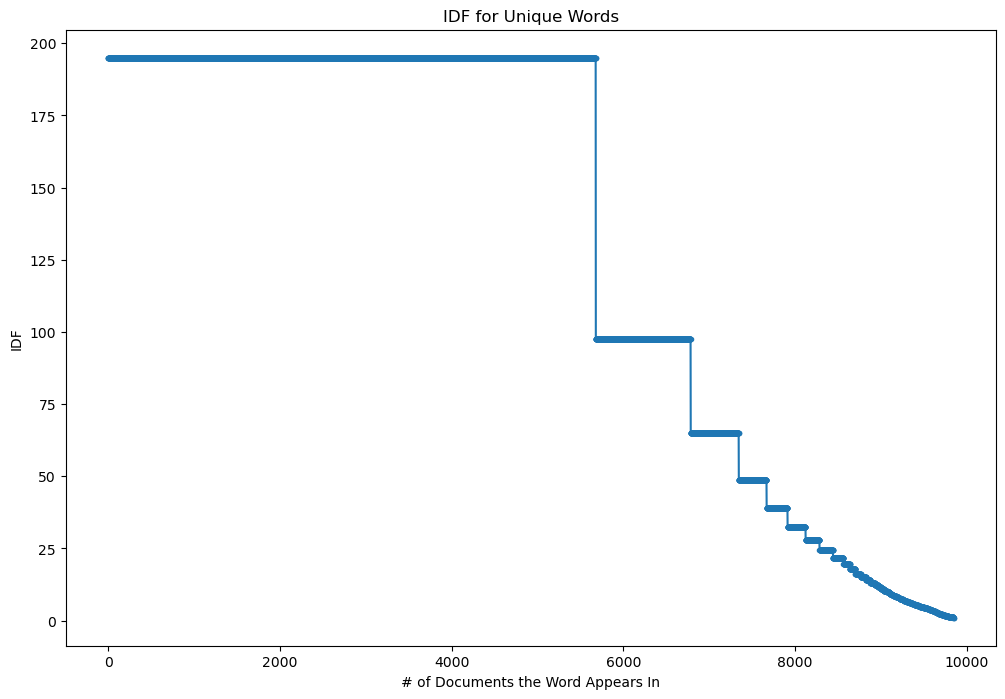

In [40]:
# A simple way to calculate idf for demonstration.
# Note that this function relies on the globally defined df variable.
def idf(word):
    n_occurrences = sum([1 for doc in df['clean_norm_token'] if word in doc])
    return len(df) / n_occurrences

# Get a list of unique words
unique_words = pd.Series(' '.join(df['clean_norm_token']).split()).unique()

# Create a DataFrame to store the unique words
idf_data = pd.DataFrame({'word': unique_words})

# Calculate the IDF for each word and store it in a new 'idf' column
idf_data['idf'] = idf_data['word'].apply(idf)

# Sort the DataFrame by IDF values in descending order
idf_data = idf_data.sort_values(by='idf', ascending=False)

# Create a line graph with IDF on the y-axis and the number of documents on the x-axis
plt.figure(figsize=(12, 8))
plt.plot(range(1, len(idf_data) + 1), idf_data['idf'], marker='.', linestyle='-')
plt.xlabel('# of Documents the Word Appears In')
plt.ylabel('IDF')
plt.title('IDF for Unique Words')
plt.show()

In [41]:
# calculating the inverse document frequency metric for each word
import pandas as pd

# Define a function to calculate IDF for a given word
def calculate_idf(word, documents):
    num_documents_containing_word = sum(1 for doc in documents if word in doc)
    if num_documents_containing_word > 0:
        return len(documents) / num_documents_containing_word
    else:
        return 0

# Assuming you have a DataFrame 'df' with a column 'clean_norm_token' containing tokenized text
documents = df['clean_norm_token'].tolist()

# Get a list of unique words from all documents
unique_words = set(word for doc in documents for word in doc)

# Create a dictionary to store IDF values for each word
idf_values = {}

# Calculate IDF for each unique word
for word in unique_words:
    idf = calculate_idf(word, documents)
    idf_values[word] = idf

# Create a DataFrame to store the IDF values
idf_df = pd.DataFrame(idf_values.items(), columns=['Word', 'IDF'])

# Sort the DataFrame by IDF values in descending order
idf_df = idf_df.sort_values(by='IDF', ascending=False)

# Display the IDF values for each word
# Display the top 5 words with the highest IDF values
top_words_with_idf = idf_df.head(5)
print("Top 5 Words by IDF:")
print(top_words_with_idf)

# Display the bottom 5 words with the lowest IDF values
bottom_words_with_idf = idf_df.tail(5)
print("\nBottom 5 Words by IDF:")
print(bottom_words_with_idf)



Top 5 Words by IDF:
   Word       IDF
37    '  3.305085
2     q  1.839623
6     8  1.741071
9     7  1.741071
36    9  1.695652

Bottom 5 Words by IDF:
   Word       IDF
17    c  1.077348
5     r  1.077348
8     o  1.005155
20    n  1.000000
0     e  1.000000


### This visual and df tells me that there is a very wide range of IDF values across my corpus, which mean a mix of common and rare words

## What is the distribution of the languages?

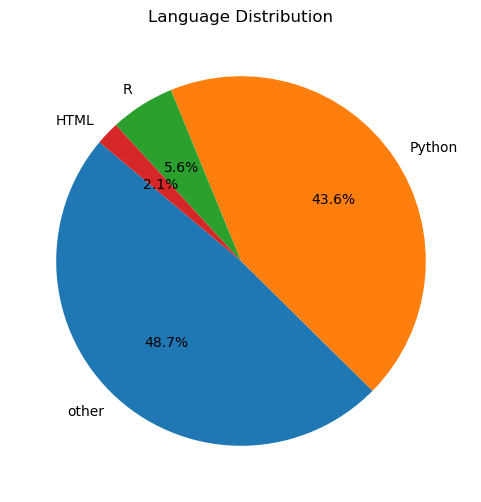

In [43]:
import matplotlib.pyplot as plt
# Assuming df is your DataFrame
# Get the value counts for the 'language' column
language_counts = df['language'].value_counts().head(4)
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(language_counts, labels=language_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Language Distribution')
plt.show()

# Exploration

## What are the distributions of words in each place

In [46]:
word_counts = {}  # Define word_counts as an empty dictionary

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Count the words and store the count in the dictionary
    word_counts[language] = len(words)

# Create a DataFrame from the word counts dictionary
word_counts_df = pd.DataFrame(word_counts.items(), columns=['language', 'word_count'])

# Display the word counts
print(word_counts_df)
transposed_df = word_counts_df.transpose()
print(transposed_df)

  language  word_count
0    other       21831
1   Python       22980
2        R        1882
3     HTML         476
                0       1     2     3
language    other  Python     R  HTML
word_count  21831   22980  1882   476


## Question 1: What are some of the most occuring words in each languge?

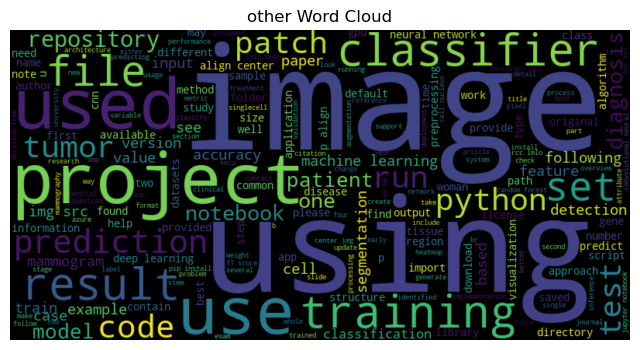

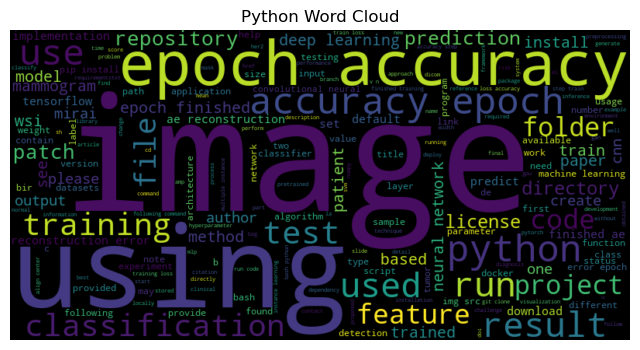

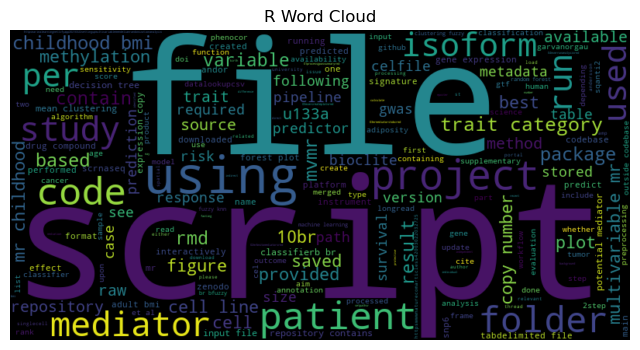

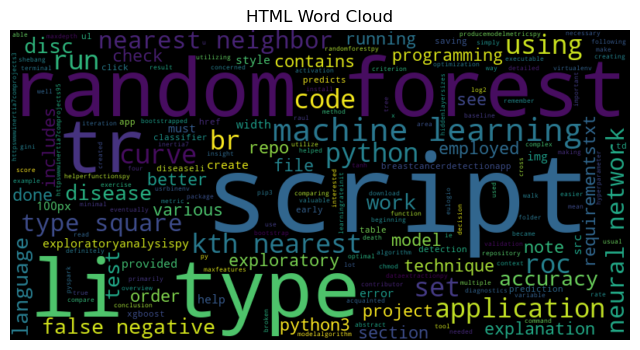

In [50]:
# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    # Check if there are words to generate a word cloud from
    if len(words) > 0:
        # Convert the list of words into a single string
        words_text = ' '.join(words)
        # Create a word cloud for the language
        wordcloud = WordCloud(width=800, height=400).generate(words_text)
        # Plot the word cloud
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'{language} Word Cloud')
        plt.axis('off')
        plt.show()
    else:
        print(f'No words to generate a word cloud for {language}')

### Answer 1: From this visualization I can see a few things 
* 'image' tend to be in Python and other
* 'script' tend to be in R and HTML

There are words that correspond with multiple language

### Question 2: Let's narrow it down. What are the high percentages words are used in each language?

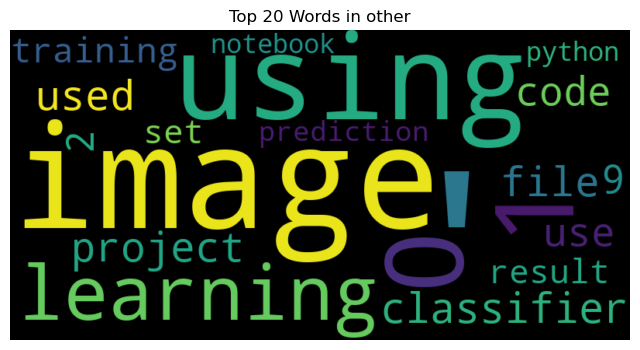

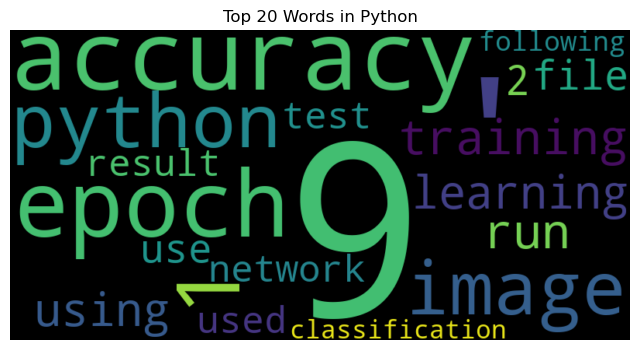

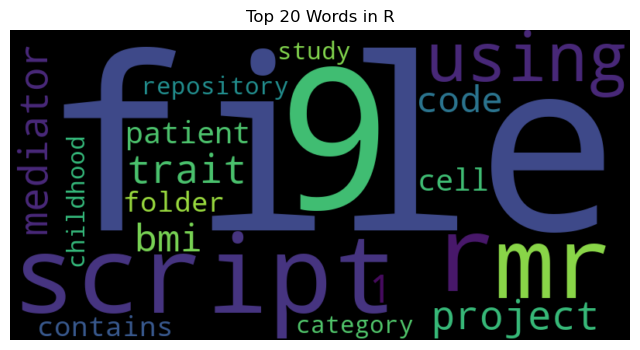

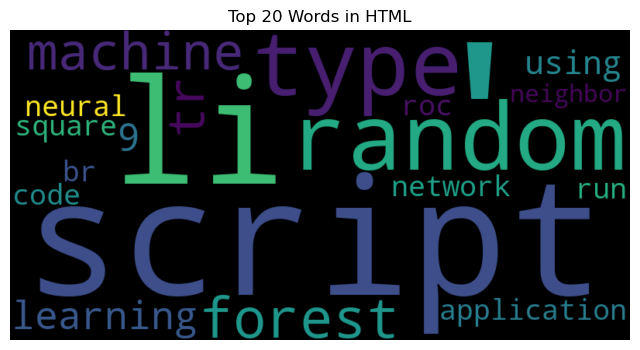

Proportion of Top 20 Words in other:
'             0.019605
image         0.007146
using         0.006230
1             0.005405
0             0.005222
learning      0.005085
classifier    0.004855
project       0.004764
used          0.004718
file          0.004718
9             0.004352
code          0.004306
use           0.004260
2             0.004077
training      0.004031
set           0.003619
result        0.003573
prediction    0.003527
python        0.003206
notebook      0.003115
dtype: float64

Proportion of Top 20 Words in Python:
9                 0.030374
'                 0.008616
accuracy          0.008268
epoch             0.007485
1                 0.006832
python            0.006789
image             0.006614
training          0.006484
run               0.006440
learning          0.005875
using             0.005875
2                 0.004700
file              0.004482
use               0.004395
used              0.003829
test              0.003786
result           

In [52]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary to store the top words for each language
top_words_by_language = {}

# Create a dictionary to store the total word counts for each language
total_word_counts_by_language = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()
    
    # Count the words and store the count in the dictionary
    word_counts = pd.Series(words).value_counts()
    total_word_counts_by_language[language] = len(words)
    
    # Get the top 20 words for the language
    top_words = word_counts.head(20)
    
    # Store the top words in the dictionary
    top_words_by_language[language] = top_words

# Create a word cloud for the top 20 words in each language
for language, top_words in top_words_by_language.items():
    if len(top_words) > 0:
        wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(top_words)
        plt.figure(figsize=(8, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.title(f'Top 20 Words in {language}')
        plt.axis('off')
        plt.show()
    else:
        print(f'No top words to generate a word cloud for {language}')

# Calculate and display the proportion of the top 20 words for each language
for language, top_words in top_words_by_language.items():
    total_words = total_word_counts_by_language[language]
    proportion = top_words / total_words
    print(f'Proportion of Top 20 Words in {language}:\n{proportion}\n')


### Answer 3: From this i can see:
* image is the most other language
* accuracy is the most used in Python
* file is the most used in R
* script is the most used in HTML

## Hypothesis 1

There is a relationship between the presence of a specific word in a text and the prediction of the language it is written in. 


* Null Hypothesis (H0): There is no significant relationship between the presence of a specific word in a text and the prediction of the language it is written in.

* Alternative Hypothesis (H1): The presence of specific words in a text significantly influences the accuracy of predicting the language it is written in. 


In [54]:
# doing stat test between clean_norm_token and language as the target variable

# I will use Chi-squared test for independence
import pandas as pd
from scipy.stats import chi2_contingency

# Assuming you have a DataFrame 'df' with columns 'clean_norm_token' and 'language'
# Create a contingency table
contingency_table = pd.crosstab(df['clean_norm_token'], df['language'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)
print("Print Expected frequencies table to see the table")




Chi-squared statistic: 569.7863777089783
p-value: 0.18130101387009392
Degrees of freedom: 540
Print Expected frequencies table to see the table


* This test shows that there are no significant relationship, and I will fail to reject the Null hypothesis

## Question 3: Are there any words that uniquely identify each language?

In [58]:
# Create a dictionary to store the top 10 unique words for each language
top_unique_words_by_language = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]

    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Count the unique words and store them in the dictionary
    unique_words = list(set(words))

    # Get the top 10 unique words for the language
    top_unique_words = unique_words[:10]

    # Store the top unique words in the dictionary
    top_unique_words_by_language[language] = top_unique_words

# Display the top 10 unique words for each language
for language, top_words in top_unique_words_by_language.items():
    print(f'Top 10 Unique Words in {language}:\n{top_words}\n')


Top 10 Unique Words in other:
['densenet', 'specifiy', 'chien', 'httpwwwsleeppitteducontentaspid1484subid2316', 'maxepochfrozen', 'breath', 'usable', 'benignity', 'selftests', 'logging']

Top 10 Unique Words in Python:
['densenet', 'metastaz', 'gradcam', 'maxepochfrozen', 'thumbnail', '102748', 'usable', 'logging', 'localtoglobal', 'sa']

Top 10 Unique Words in R:
['limitation', 'rerun', 'mammographic', 'installed', 'phenotypic', 'lab', 'httpbioconductororgshieldsbuilddevelbiocgenefusvg', 'algorithm', 'httpsarchiveicsuciedumldatasetsbreastcancerwisconsin', 'rors']

Top 10 Unique Words in HTML:
['conclusion', 'install', 'chmod', 'help', 'criterion', 'walk', 'simply', 'httpswwwinertia7comprojects95', 'model', 'definitely']



### Answer 3: These are all the unique words that identify each language

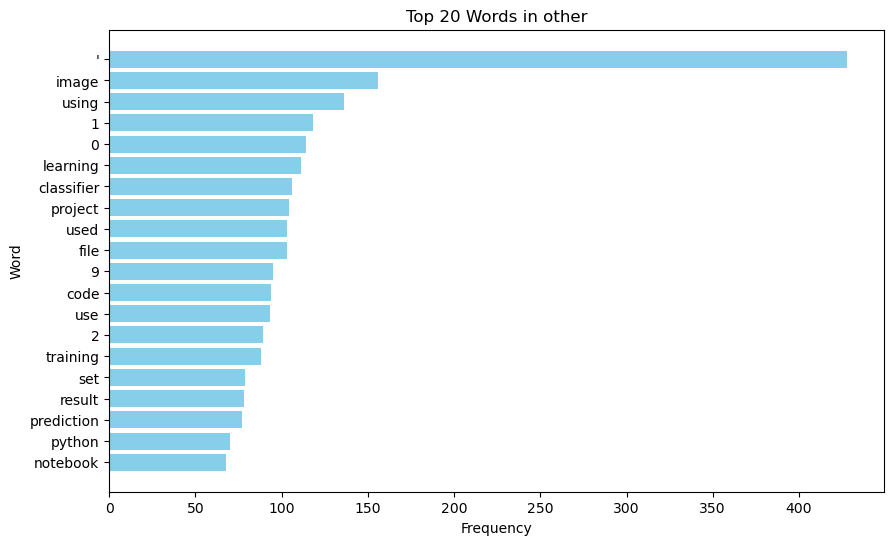

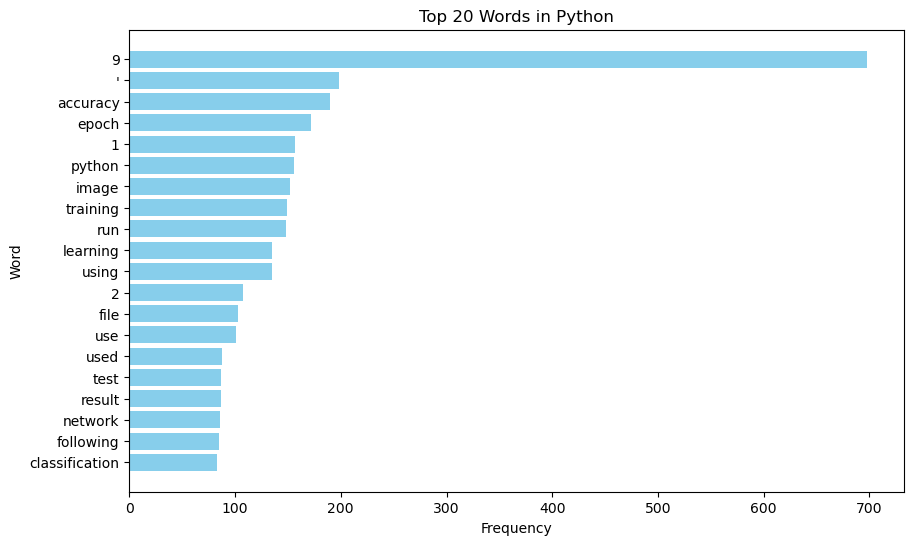

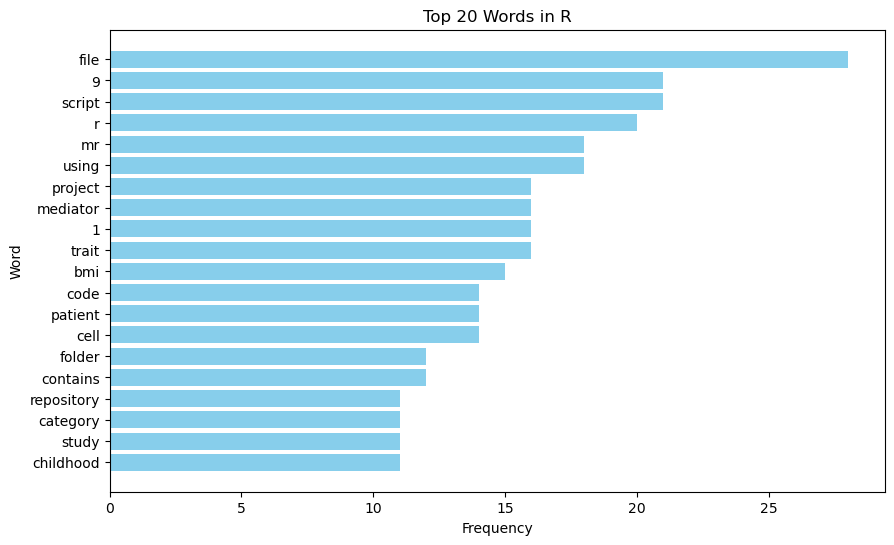

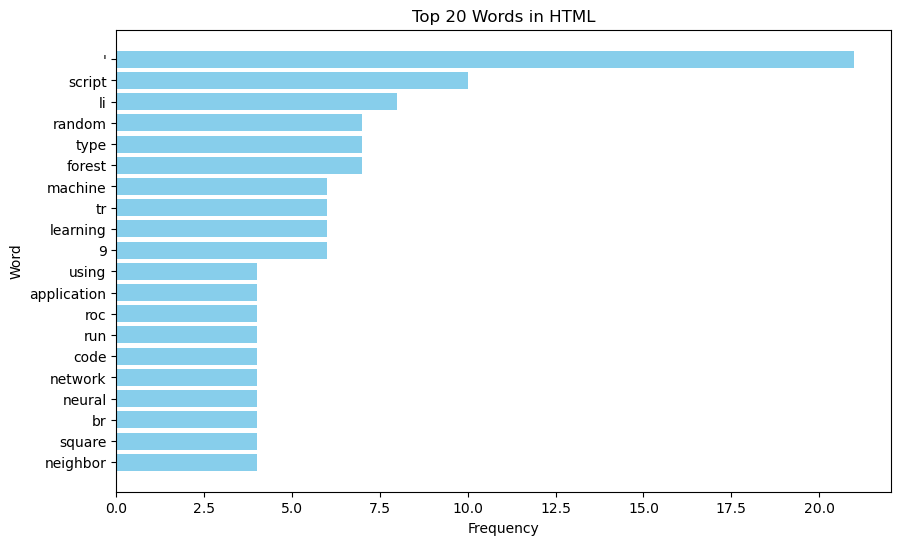

In [59]:
# Create a dictionary to store the top 20 words for each language
top_words_by_language = {}

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]

    # Combine all tokenized text for the language and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Count the words and store the count in the dictionary
    word_counts = pd.Series(words).value_counts()

    # Get the top 20 words for the language
    top_words = word_counts.head(20)

    # Store the top words in the dictionary
    top_words_by_language[language] = top_words

# Create horizontal bar plots for the top 20 words in each language
for language, top_words in top_words_by_language.items():
    if len(top_words) > 0:
        plt.figure(figsize=(10, 6))
        plt.barh(top_words.index, top_words.values, color='skyblue')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.title(f'Top 20 Words in {language}')
        plt.gca().invert_yaxis()  # Invert the y-axis to display the highest frequency at the top
        plt.show()
    else:
        print(f'No top words to generate a bar plot for {language}')

## Hypothesis 2

There is a relationship between the word epoch in the ReadMe file with the language Python.

* Null Hypothesis(H0): There is no significant relationship between the word epoch in the ReadMe file with the language Python
* Alternative Hypothesis(H1): The presence of epoch in the ReadMe file have a significantly relationship with the language it is written in

In [62]:
# Create a contingency table
contingency_table = pd.crosstab(df['clean_norm_token'].str.contains('epoch', case=False), df['language'])

# Perform the chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 4.02649688253915
p-value: 0.25861712357803024
Degrees of freedom: 3


* This test shows that there are no significant relationship, and I will fail to reject the Null hypothesis

## Question 4: Can groups of two words show more relationship with the targeted language?

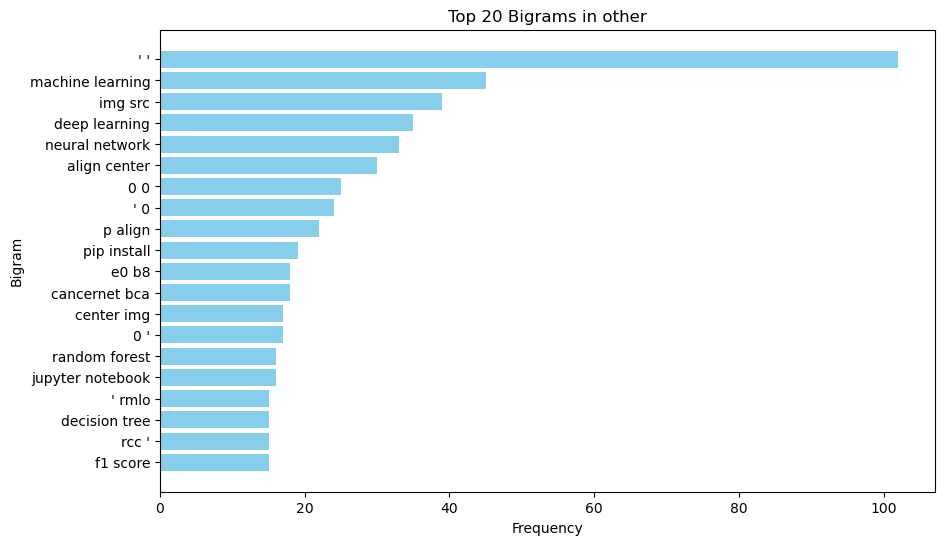

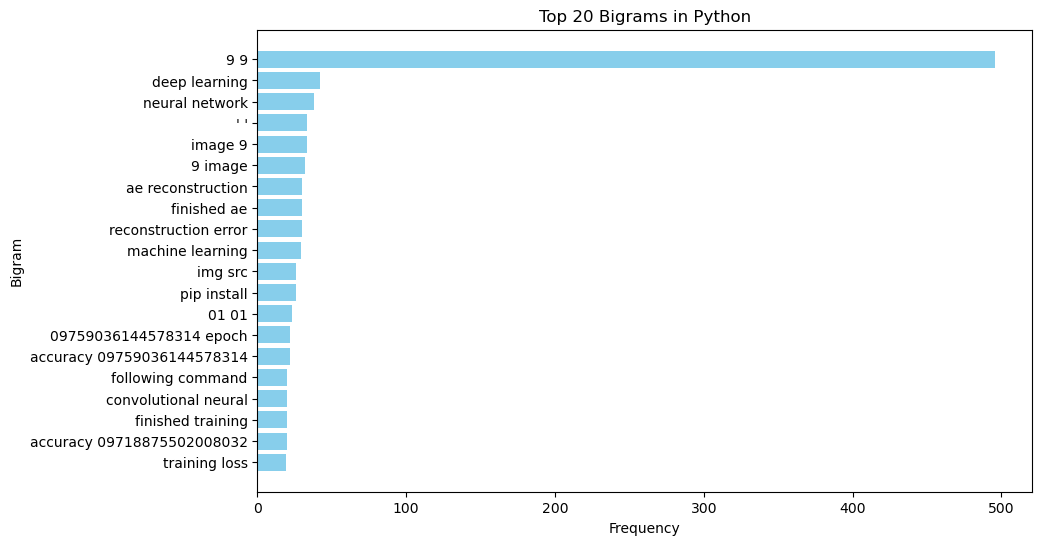

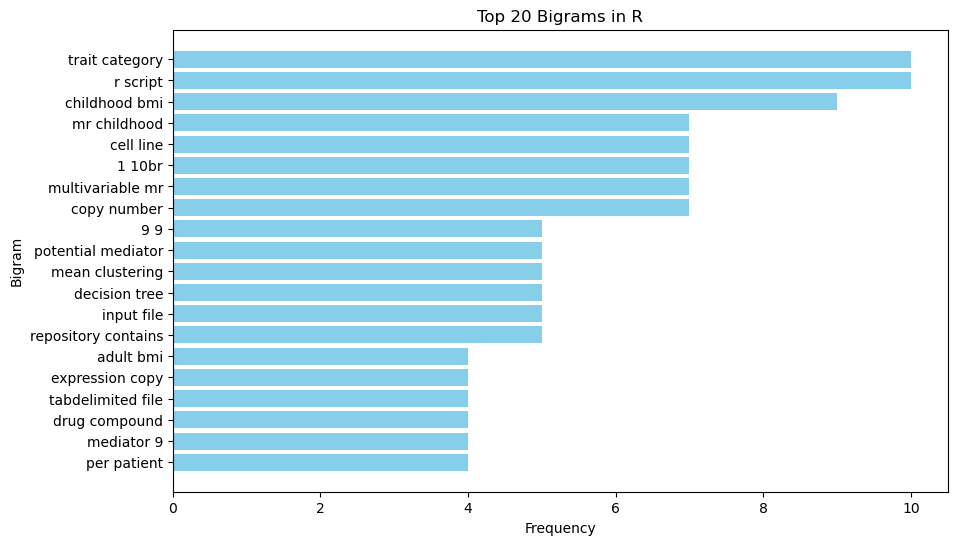

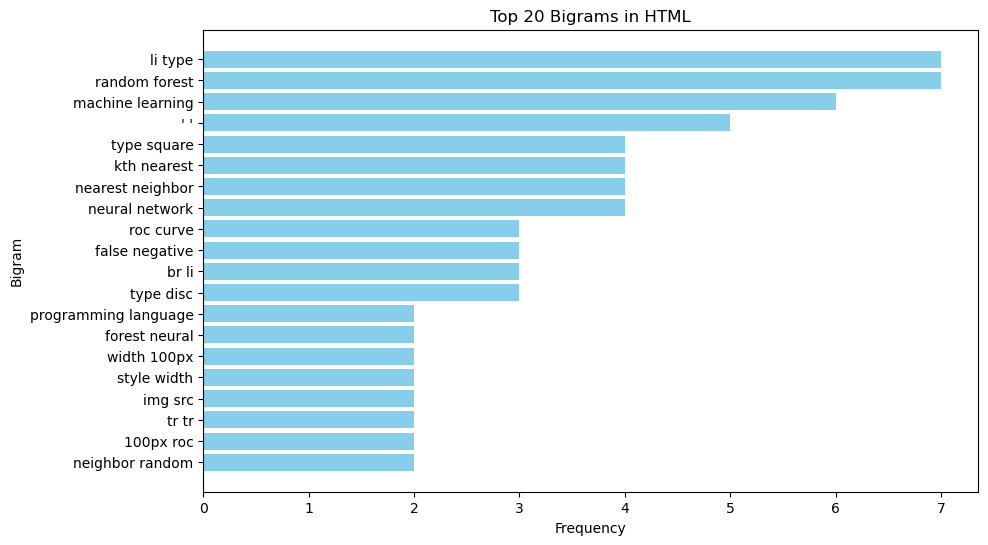

In [65]:
# Create Bigram
# Create a function to generate bigram statistics for each language
def generate_bigram_stats(language_df):
    # Create a DataFrame to store the top bigrams and their frequencies
    top_bigrams_df = pd.DataFrame(columns=['Bigram', 'Frequency'])

    # Combine all tokenized text and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Create bigrams from the words and convert them to string
    bigram_list = list(bigrams(words))
    bigram_strings = [' '.join(bigram) for bigram in bigram_list]

    # Count the bigrams
    bigram_counts = pd.Series(bigram_strings).value_counts()

    # Get the top 20 bigrams
    top_bigrams = bigram_counts.head(20)

    # Add the top bigrams and their frequencies to the DataFrame
    top_bigrams_df['Bigram'] = top_bigrams.index
    top_bigrams_df['Frequency'] = top_bigrams.values

    # Sort the top bigrams by frequency in descending order
    top_bigrams_df = top_bigrams_df.sort_values(by='Frequency', ascending=False)

    # Create a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_bigrams_df['Bigram'], top_bigrams_df['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    plt.title(f'Top 20 Bigrams in {language_df["language"].iloc[0]}')
    plt.gca().invert_yaxis()  # Invert the y-axis to display the highest frequency at the top
    plt.show()

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Generate and display bigram statistics for the language
    generate_bigram_stats(language_df)

## Answer 4: With grouping of two words, we can see the language can be uniquely identify

## Hypothesis 3

There is a significant relationship between the word 'li type' to the language HTML


* Null Hypothesis(H0): There is no significant relationship between the word 'li type' in the ReadMe file with the language HTML
* Alternative Hypothesis(H1): The presence of 'li type' in the ReadMe file have a significantly relationship with the language HTML

In [67]:
# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(df['clean_norm_token'].str.contains('random forest'), df['language'] == 'HTML')

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the test results
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 0.05209257698109859
p-value: 0.8194612342651102
Degrees of freedom: 1


* This test shows that there is a significant relationship between 'li type' to HTML

## Answer 5: can the language be more identifiable by grouping 3 words together?

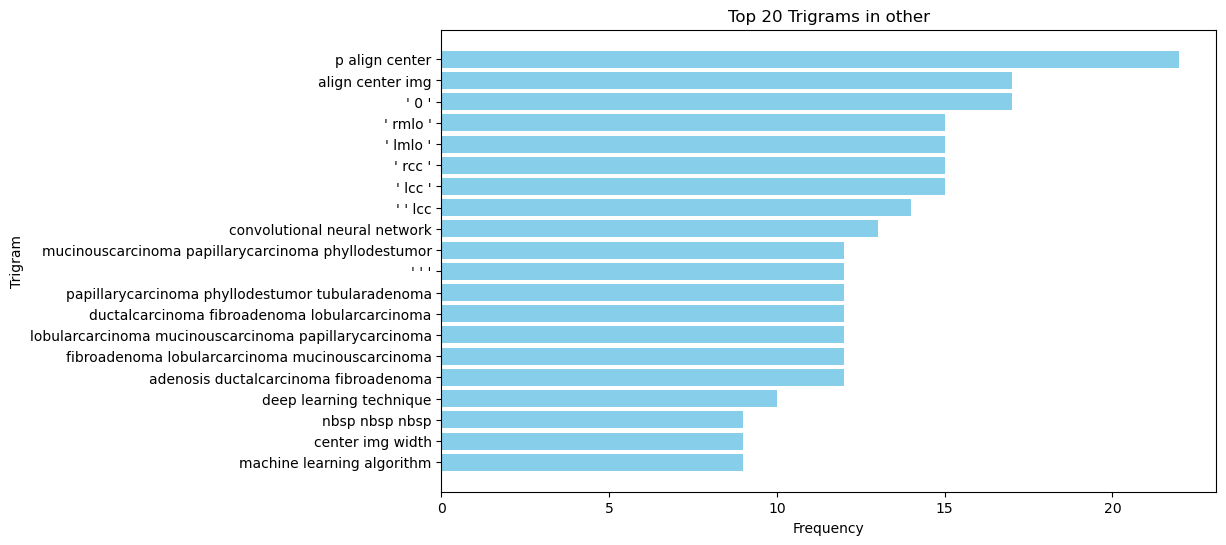

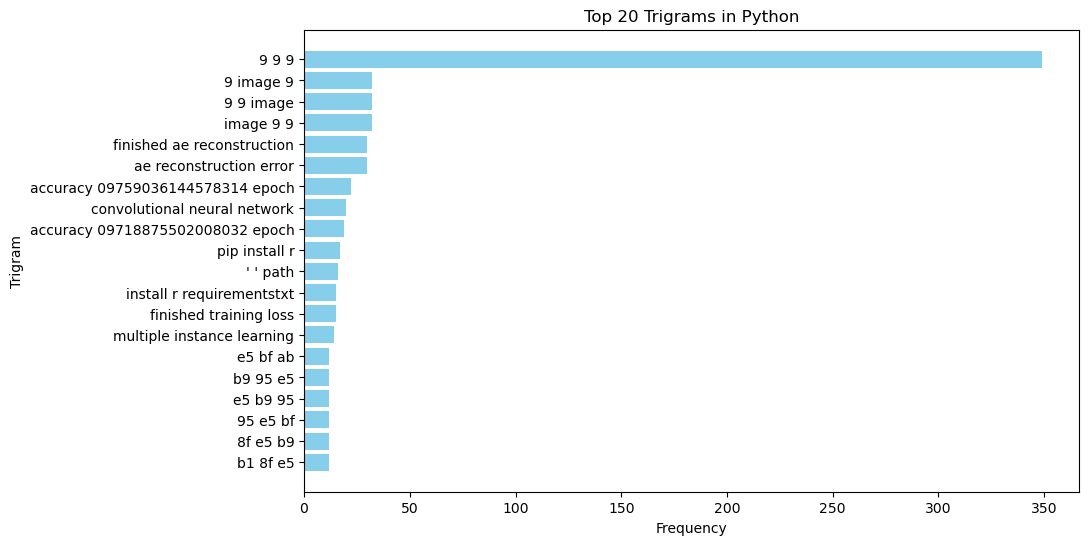

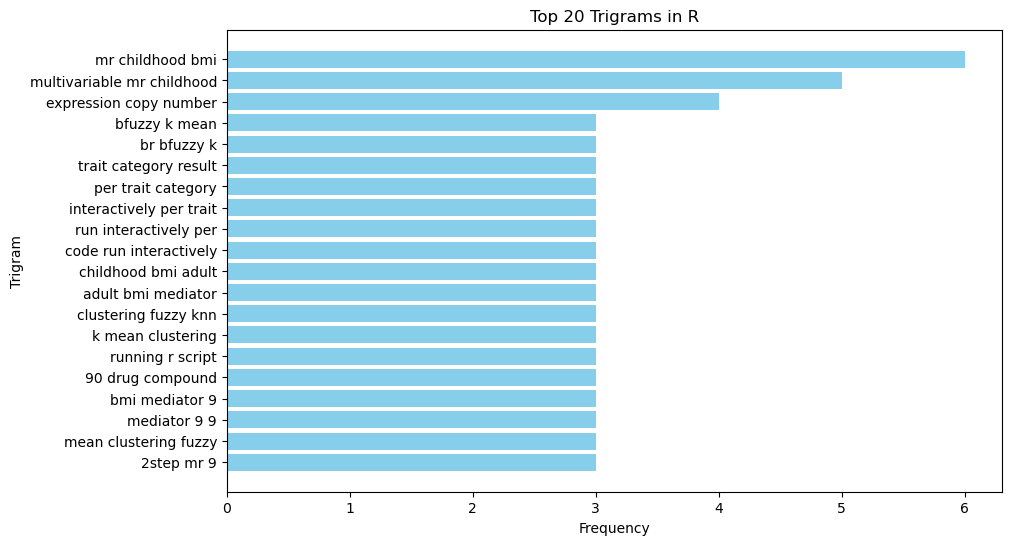

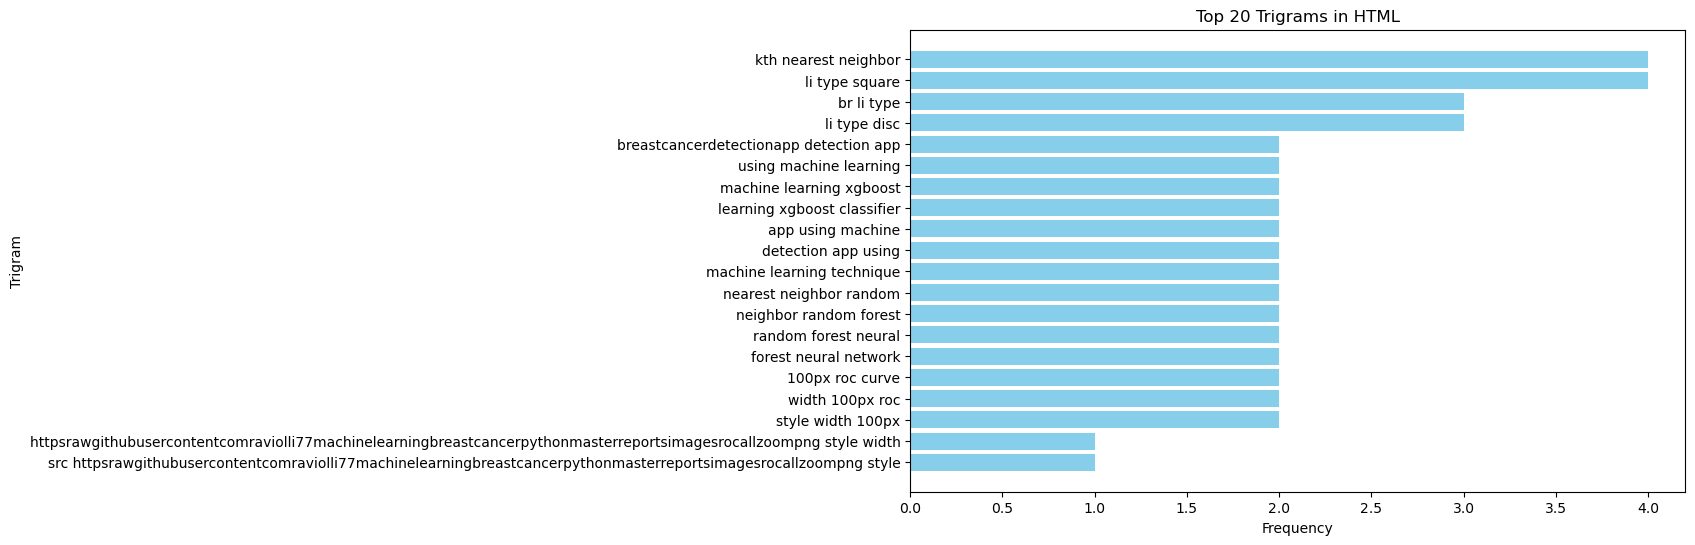

In [70]:
# Trigam
# Create a function to generate trigram statistics for each language
def generate_trigram_stats(language_df):
    # Create a DataFrame to store the top trigrams and their frequencies
    top_trigrams_df = pd.DataFrame(columns=['Trigram', 'Frequency'])

    # Combine all tokenized text and split it into words
    words = ' '.join(language_df['clean_norm_token']).split()

    # Create trigrams from the words and convert them to string
    trigram_list = list(trigrams(words))  # Use trigrams function
    trigram_strings = [' '.join(trigram) for trigram in trigram_list]

    # Count the trigrams
    trigram_counts = pd.Series(trigram_strings).value_counts()

    # Get the top 20 trigrams
    top_trigrams = trigram_counts.head(20)

    # Add the top trigrams and their frequencies to the DataFrame
    top_trigrams_df['Trigram'] = top_trigrams.index
    top_trigrams_df['Frequency'] = top_trigrams.values

    # Sort the top trigrams by frequency in descending order
    top_trigrams_df = top_trigrams_df.sort_values(by='Frequency', ascending=False)

    # Create a horizontal bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_trigrams_df['Trigram'], top_trigrams_df['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Trigram')
    plt.title(f'Top 20 Trigrams in {language_df["language"].iloc[0]}')
    plt.gca().invert_yaxis()  # Invert the y-axis to display the highest frequency at the top
    plt.show()

# Iterate through each unique language in your DataFrame
for language in df['language'].unique():
    # Filter the DataFrame for the specific language
    language_df = df[df['language'] == language]
    
    # Generate and display trigram statistics for the language
    generate_trigram_stats(language_df)

## Answer 5: The languages are better identifiable when grouping 3 words together

## Hypothesis 4

'expression copy number' has a relationship with the language R

* Null(H0): 'expression copy number' does not have a relationship with the language R
* Alternative(H1): 'expression copy number' have a relationship with the language R

In [72]:
# stat test for 'expression copy number' and language R

from scipy.stats import chi2_contingency

# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(df['clean_norm_token'].str.contains('p align center'), df['language'] == 'other')

# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the test results
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)


Chi-squared statistic: 5.5538246799431015
p-value: 0.018440350154313737
Degrees of freedom: 1


This barely show a nonrelationship

In [73]:
# stat test for 'expression copy number' and language R
# Create a contingency table for the chi-square test
contingency_table = pd.crosstab(df['clean_norm_token'].str.contains('pip install r'), df['language'] == 'Python')
# Perform the chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)
# Display the test results
print("Chi-squared statistic:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)

Chi-squared statistic: 8.740672993335265
p-value: 0.0031118964698259115
Degrees of freedom: 1


# Modeling

* Split, get base line, get rid fo the "None" column, and TfidVectorizer

In [77]:
# Assuming you already have 'df' loaded with your data
df = df[df['language'] != 'None']
X = df.clean_norm_token
y = df.language
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
baseline_acc = y_train.value_counts().max() / y_train.shape[0] * 100  # Fix this line
print(f'Baseline accuracy for the training set: {round(baseline_acc, 2)}.')
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)

Baseline accuracy for the training set: 48.53.


We are going to TfidVectorize to reduce dimensionality and balance the data

In [80]:
# Create and train a Logistic Regression model
logistic_reg = LogisticRegression(random_state=42)
logistic_reg.fit(X_train_tfidf, y_train)
logistic_reg_val_predictions = logistic_reg.predict(X_val_tfidf)
logistic_reg_val_accuracy = accuracy_score(y_val, logistic_reg_val_predictions)
logistic_reg_val_report = classification_report(y_val, logistic_reg_val_predictions)

# Create and train a Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train_tfidf, y_train)
decision_tree_val_predictions = decision_tree.predict(X_val_tfidf)
decision_tree_val_accuracy = accuracy_score(y_val, decision_tree_val_predictions)
decision_tree_val_report = classification_report(y_val, decision_tree_val_predictions)

# Create and train a K-Nearest Neighbors (KNN) model
knn = KNeighborsClassifier()
knn.fit(X_train_tfidf, y_train)
knn_val_predictions = knn.predict(X_val_tfidf)
knn_val_accuracy = accuracy_score(y_val, knn_val_predictions)
knn_val_report = classification_report(y_val, knn_val_predictions)

# Create and train a Random Forest model
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train_tfidf, y_train)
random_forest_val_predictions = random_forest.predict(X_val_tfidf)
random_forest_val_accuracy = accuracy_score(y_val, random_forest_val_predictions)
random_forest_val_report = classification_report(y_val, random_forest_val_predictions)

# Print the validation accuracies and classification reports
print("Logistic Regression Validation Accuracy: {:.2f}%".format(logistic_reg_val_accuracy * 100))
print("Logistic Regression Classification Report:\n", logistic_reg_val_report)
print("Decision Tree Validation Accuracy: {:.2f}%".format(decision_tree_val_accuracy * 100))
print("Decision Tree Classification Report:\n", decision_tree_val_report)
print("K-Nearest Neighbors Validation Accuracy: {:.2f}%".format(knn_val_accuracy * 100))
print("K-Nearest Neighbors Classification Report:\n", knn_val_report)
print("Random Forest Validation Accuracy: {:.2f}%".format(random_forest_val_accuracy * 100))
print("Random Forest Classification Report:\n", random_forest_val_report)


Logistic Regression Validation Accuracy: 55.17%
Logistic Regression Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00         2
      Python       0.67      0.50      0.57        12
           R       0.00      0.00      0.00         2
       other       0.50      0.77      0.61        13

    accuracy                           0.55        29
   macro avg       0.29      0.32      0.29        29
weighted avg       0.50      0.55      0.51        29

Decision Tree Validation Accuracy: 51.72%
Decision Tree Classification Report:
               precision    recall  f1-score   support

        HTML       0.00      0.00      0.00         2
      Python       0.67      0.50      0.57        12
           R       0.00      0.00      0.00         2
       other       0.50      0.69      0.58        13

    accuracy                           0.52        29
   macro avg       0.29      0.30      0.29        29
weighted avg 

Logistic Regression seem to have the most recall with the best fit data and is above baseline. I shall test on logistic regression

In [87]:
# Use the trained Logistic Regression model for predictions on the X_test dataset
logistic_reg_test_predictions = logistic_reg.predict(X_test_tfidf)
logistic_reg_test_accuracy = accuracy_score(y_test, logistic_reg_test_predictions)
# Print the test accuracy and classification report for Logistic Regression
print("Logistic Regression Test Accuracy: {:.2f}%".format(logistic_reg_test_accuracy * 100))

Logistic Regression Test Accuracy: 60.00%


In [89]:
# Choose the model for predictions, e.g., logistic_reg
chosen_model = logistic_reg
# Make predictions using the chosen model
model_predictions = chosen_model.predict(X_test_tfidf)
# Create a DataFrame with the test data, actual labels, and predictions
prediction_df = pd.DataFrame({
    'Text': X_test,  # This assumes 'X_test' contains the text data
    'Predicted_Language': model_predictions,  # Model predictions
    'Actual_Language': y_test,  # Actual language labels
    })
# Save the DataFrame to a CSV file
prediction_df.to_csv('language_predictions.csv', index=False)
prediction = pd.read_csv('language_predictions.csv')
prediction

,Text,Predicted_Language,Actual_Language
0,breastcancersklearn cancerpython sklearn pytho...,Python,Python
1,breastcancersurvivalintegration,other,Python
2,rsna screening mammography detection environme...,Python,Python
3,share journey share journey one first five app...,other,other
4,breastcancerprediction chooseyourown project h...,other,R
5,breastcancerwisconsin httparchiveicsuciedumlma...,other,Python
6,occurrence taken openml breastcancer httpswwwo...,other,Python
7,classificationofbreastcancerhistologyusingdeep...,other,Python
8,improved prediction outcome identifying hetero...,Python,Python
9,diagnosis predictor overview diagnosis app mac...,Python,Python


# Conclusion

My Model's accuracy is at a whopping 60% which is about 12% above baseline, but I will not encourage to use this model to predict the text to its language.


# What to do next? 

* to have more time to web scrape all medical dictionary to rule out the non essential medical words in this project. 
* With more time I can scrape more data to include more reading of other languages to include the top 10 instead of just top 3. 